In [1]:
# Data Handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Text Processing
import re
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# PyTorch for Neural Networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Gensim for Word Vectors
import os
import gensim.downloader as api
from gensim.models import KeyedVectors
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch

# Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, Dataset



In [2]:
# Read the CSV file into a DataFrame
def read_csv(path):
    df = pd.read_csv(path)
    return df


In [3]:
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()

    # Replace '\\' with a space
    text = re.sub(r'\\', ' ', text)

    # Remove unnecessary symbols, keep only words and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    return text


In [4]:

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

class TextDataset(Dataset):
    def __init__(self, texts, labels, max_len):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize and pad/truncate
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [5]:
df =  read_csv('/kaggle/input/nlp-ass-3/train.csv')


In [6]:
df['processed'] = df['text'].apply(preprocess)


In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [8]:

# Assuming 'texts' and 'labels' are lists containing your data
max_len = 256
batch_size = 32
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Create the dataset and dataloader for training
train_dataset = TextDataset(texts=train_df['processed'], labels=train_df['label'], max_len=max_len)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Similarly for validation
val_dataset = TextDataset(texts=val_df['processed'], labels=val_df['label'], max_len=max_len)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)


# Similarly for testing
df_test =  read_csv('/kaggle/input/nlp-ass-3/train.csv')
df_test['processed'] = df_test['text'].apply(preprocess)

test_dataset = TextDataset(texts=df_test['processed'], labels=df_test['label'], max_len=max_len)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)


In [9]:
import torch.nn as nn
from transformers import RobertaModel

class CustomRobertaClassifier(nn.Module):
    def __init__(self, num_labels):
        super(CustomRobertaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # outputs[1] returns the pooled output
        logits = self.classifier(pooled_output)
        return logits


In [10]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
 

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Load the model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)  # Adjust num_labels as necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [12]:
from torch.optim import AdamW

# Training setup
epochs = 10
total_steps = len(train_loader) * epochs
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
model.train()
for epoch in range(epochs):
    total_train_loss = 0
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.3f}")

print("Training complete.")

Epoch 1/10 | Train Loss: 0.849
Epoch 2/10 | Train Loss: 0.347
Epoch 3/10 | Train Loss: 0.251
Epoch 4/10 | Train Loss: 0.185
Epoch 5/10 | Train Loss: 0.143
Epoch 6/10 | Train Loss: 0.091
Epoch 7/10 | Train Loss: 0.064
Epoch 8/10 | Train Loss: 0.044
Epoch 9/10 | Train Loss: 0.028
Epoch 10/10 | Train Loss: 0.026
Training complete.


Test Accuracy: 97.40%
Macro F1 Score: 0.9740


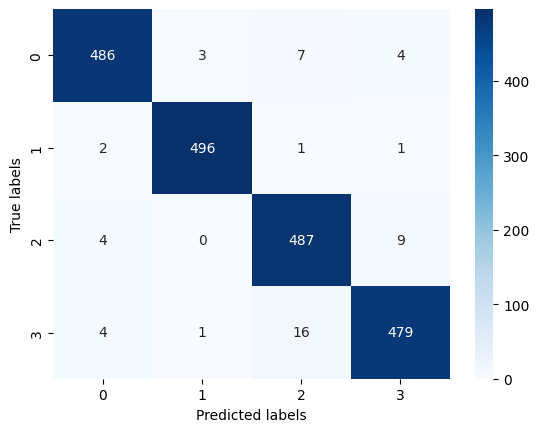

In [15]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def evaluate(model, data_loader, device):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs[0]
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    macro_f1 = f1_score(true_labels, predictions, average='macro')
    
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    
    # Plotting the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()
    
    return predictions, true_labels

# Execute evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions, true_labels = evaluate(model, test_loader, device)


In [17]:
# Assuming your original test DataFrame is named 'test_df' and it contains a 'text' column
df_test['preds'] = predictions

# Save to CSV,
df_test[['index','text','label','preds']].to_csv('bert_test.csv', index=False)


In [ ]:
model_save_path = "bert_model.pth"

# Save the model state
torch.save(model.state_dict(), model_save_path)
